In [56]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [30]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [31]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [40]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [44]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [54]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [55]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 9s 7ms/step - loss: 0.6356 - val_loss: 0.6204
Epoch 2/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6135 - val_loss: 0.6187
Epoch 3/5
1418/1418 [==============================] - 9s 7ms/step - loss: 0.6086 - val_loss: 0.6151
Epoch 4/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6074 - val_loss: 0.6137
Epoch 5/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6079 - val_loss: 0.6138


In [69]:
d = 30

class Autoencoder(keras.Model):
    
    def __init__(self,**kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        
        self.Encoder = keras.Sequential(
            layers.Dense(d, activation="tanh"))
        
        self.Decoder = keras.Sequential(
            layers.Dense(28*28, activation="tanh"))
        
    def call(self, inputs):
        h = self.Encoder(inputs)
        out = self.Decoder(h)

        return out
    
    
    

model = Autoencoder()
model.compile(optimizer = "adam", loss = "mse")


In [104]:
model = keras.Sequential()
model.add(layers.Flatten(input_shape=(784,)))
model.add(layers.Dense(d, activation="tanh"))
model.add(layers.Dense(784, activation="tanh"))

model.compile(optimizer = "adam", loss = "mse")
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 30)                23550     
_________________________________________________________________
dense_51 (Dense)             (None, 784)               24304     
Total params: 47,854
Trainable params: 47,854
Non-trainable params: 0
_________________________________________________________________


In [139]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
#x_train = np.reshape(x_train, (60000,784))

x_test = np.expand_dims(x_test, -1)
#x_test = np.reshape(x_test, (10000,784))
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [130]:
history = model.fit(x_train, x_train, batch_size=128, epochs=10)

new = model.predict(x_test)

Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0207
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0207


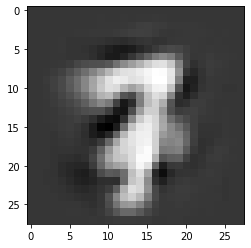

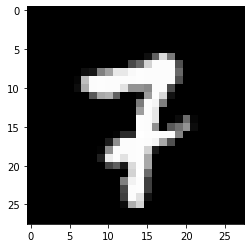

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [135]:
n = 328

fig = plt.figure
plt.imshow(np.reshape(new[n], (28,28)), cmap='gray')
plt.show()

fig = plt.figure
plt.imshow(np.reshape(x_test[n], (28,28)), cmap='gray')
plt.show()

print(y_test[n])

In [150]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='tanh', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [151]:
history = autoencoder.fit(x_train, x_train, batch_size=128, epochs=1)

new = autoencoder.predict(x_test)

469/469 [==============================] - 56s 120ms/step - loss: 0.0403


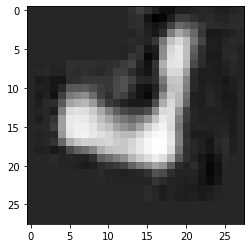

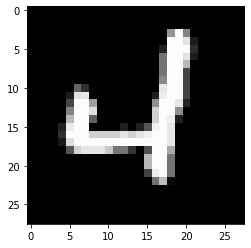

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [155]:
n = 399

fig = plt.figure
plt.imshow(np.reshape(new[n], (28,28)), cmap='gray')
plt.show()

fig = plt.figure
plt.imshow(np.reshape(x_test[n], (28,28)), cmap='gray')
plt.show()

print(y_test[n])